Measuring the performance of members of the Australian Parliament
=============================

This notebook uses data gathered from <a href="https://theyvoteforyou.org.au">
theyvoteforyou.org.au</a> using their API.

The ultimate goal of this project is to help people get to know their representatives, by defining several quantitative metrics that can be used to rate representatives' performance and compare them to each other.

Here's how I retrieved the data:

In [4]:
#%% GETTING THE DATA FROM theyvoteforyou.org.au API:

import requests
import json
from time import sleep

filepath = ('C:/Users/jacques.pienaar/Documents/Project Map/Data_Science'
            '/TDI application/Application July2020/Challenge/')

HEADERS = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:78.0) '
    'Gecko/20100101 Firefox/78.0'}

KEY_SECRET = 'my_secret_key'

In [ ]:
session = requests.Session()
session.mount('http://', requests.adapters.HTTPAdapter(max_retries=3))

# Get data on "all people" in parliament:

all_people_url =  'https://theyvoteforyou.org.au/api/v1/people.json?key=' \
    + KEY_SECRET

_ = session.get(all_people_url, headers=HEADERS, timeout=5)
all_people = _.json()

# Get details on each member of parliament:

member_id = [i['id'] for i in all_people]
people_details = []
n = 0
for id_ in member_id:
    people_details_url = 'https://theyvoteforyou.org.au/api/v1/people/' \
                         + str(id_) + '.json?key=' + KEY_SECRET
    _ = session.get(people_details_url, headers=HEADERS, timeout=5)
    people_details.append(_.json())
    sleep(1)    #Just being careful not to spam them.
    print(n, end=' ')
    n += 1

# Get data on "all policies"

allpolicies_url = 'https://theyvoteforyou.org.au/api/v1/policies.json?key=' \
    + KEY_SECRET
_ = session.get(allpolicies_url, headers=HEADERS, timeout=5)
allpolicies = _.json()
policy_id = [i['id'] for i in allpolicies]

# Get details of each policy:

policy_details = []
n = 0
for id_ in policy_id:
    policy_details_url = 'https://theyvoteforyou.org.au/api/v1/policies/' \
                         + str(id_) + '.json?key=' + KEY_SECRET
    _ = session.get(policy_details_url, headers=HEADERS, timeout=10)
    policy_details.append(_.json())
    sleep(1)
    print(n, end=' ')
    n += 1

I saved the data to file in JSON, so I can retrieve it at any time:

In [5]:
#%% LOADING THE DATA FROM FILES

with open(filepath + 'all_people.json') as f:
    all_people = json.load(f)

with open(filepath + 'people_details.json') as f:
    people_details = json.load(f)

with open(filepath + 'policy_details.json') as f:
    policy_details = json.load(f)

The next step is to organize the data. Every vote in Parliament is called a "division". Each policy is connected to one or more divisions that either support the policy or are against the policy. Some divisions are strongly relevant to a policy, while others are only weakly relevant. In the data, we're told whether a member votes in favour or against a policy (vote = 'aye' or 'no') in each division, and whether the division is strongly or weakly relevant to the policy (strong = True or False). For convenience, I represent this as a number in {-2,-1,1,2} using the following function: 

In [6]:
#%% USEFUL FUNCTIONS
def division_support(vote,strength):
    # Given a boolean vote and boolean strength, convert into a 
    # number in [-2,-1,1,2] indicating how strongly a division
    # supports a policy.
    s = (-1)**(int(vote)+1)*(2)**(int(strength))
    return s

The code below organizes the data into dataframes for analysis:

In [7]:
#%% MAKING THE DATAFRAMES
# Uses data stored in these variables: all_people, people_details, policy_details

import pandas as pd

colnames = ['id','first','last','electorate','house','party']
people_data = pd.DataFrame(columns = colnames)

# Add basic data from all_people:
newdata = [{} for i in range(len(all_people))]
member_id = []
i = 0
for p in all_people:
    member_id.append(p['id'])
    newdata[i]['id'] = p['id']
    newdata[i]['first'] = p['latest_member']['name']['first']
    newdata[i]['last'] = p['latest_member']['name']['last']
    newdata[i]['electorate'] = p['latest_member']['electorate']
    newdata[i]['house'] = p['latest_member']['house']
    newdata[i]['party'] = p['latest_member']['party']
    i += 1

people_data = people_data.append(newdata)

# Add people details:
newdata = [{} for i in range(len(people_details))]
i=0
for p in people_details:
    newdata[i]['id'] = p['id']
    newdata[i]['rebellions'] = p['rebellions']
    newdata[i]['votes_attended'] = p['votes_attended']
    newdata[i]['votes_possible'] = p['votes_possible']
    for q in p['policy_comparisons']:
        id_ = q['policy']['id']
        colname = 'policy_' + str(id_)
        if q['voted'] and not q['policy']['provisional']:
            newdata[i][colname] = q['agreement']
    i += 1

new_columns = pd.DataFrame(newdata) 
people_data = pd.merge(people_data,new_columns,on='id')

# make a dataframe of divisions related to each policy
 
colnames = ['id', 'house', 'date', 'number', 'clock_time', 'yes_votes', 
            'no_votes', 'possible_turnout', 'rebellions']
div_data = pd.DataFrame(columns = colnames)

# Add data from policy_details:
newdata = []
i = 0
div_id = []
for p in policy_details:
    p_id = str(p['id'])
    for d in p['policy_divisions']:
        id_ = d['division']['id']
        if id_ in div_id:
            j = div_id.index(id_)
            vote = (d['vote'] == 'aye')
            strength = d['strong']
            newdata[j]['policy_'+p_id] = division_support(vote, strength)
        else:
            newdata.append({})
            newdata[i]['id'] = id_
            newdata[i]['house'] = d['division']['house']
            newdata[i]['date'] = d['division']['date']
            newdata[i]['number'] = d['division']['number']
            newdata[i]['clock_time'] = d['division']['clock_time']
            newdata[i]['yes_votes'] = d['division']['aye_votes']
            newdata[i]['no_votes'] = d['division']['no_votes']
            newdata[i]['possible_turnout'] = d['division']['possible_turnout']
            newdata[i]['rebellions'] = d['division']['rebellions']
            vote = (d['vote'] == 'aye')
            strength = d['strong']
            newdata[i]['policy_'+p_id] = division_support(vote, strength)
            div_id.append(id_)
            i += 1
            
div_data = div_data.append(newdata)

Now that we have the data, let's explore. One way to measure an MP's performance is to check their attendance to votes on important policies. But how do we know which policies are important?
One way to measure how important a policy is might be to check how many divisions are connected to it (reminder: a "division" means a vote in parliament). Let's see how the divisions are distributed per policy:

Text(0, 0.5, 'Divisions')

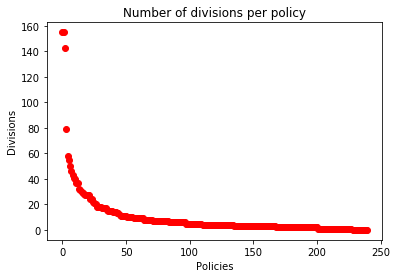

In [8]:
#PLOTTING:
import matplotlib.pyplot as plt

# How many divisions does each policy have?

num_div = []
indices = []
for i in range(len(policy_details)):
    id_ =  policy_details[i]['id']
    col = 'policy_' + str(id_)
    n = 0
    if col in div_data.columns:
        n = len(div_data[col].dropna())
    num_div.append(n) 
    indices.append(id_)

nd = pd.DataFrame({'num_divisions':num_div, 
                        'policy_id':indices})
nd = nd['num_divisions'].sort_values(ascending=False)
nd.reset_index(drop=True, inplace=True)

ax = nd.plot(style='ro', title='Number of divisions per policy')
ax.set_xlabel('Policies')
ax.set_ylabel('Divisions')

We see there are a few policies that have a very high number of divisions connected to them. These are candidates for being important policies. However, some might just have many divisions because they are highly contentious, so we need to filter those out. Conversely, some important policies might have only a few divisions connected to them, so we need another way to identify those.

Attendance is recorded in the data from the API, but does not include information about "pairing arrangements". This information is important because technically an MP's vote may still count as cast, even if they were physically absent. Also, the frequency of engaging in pairing arrangements might be an interesting metric to study in itself, for example it might indicate MPs that have many other responsibilities.

TODO: Scrape data on pairing arrangements from <a href="https://www.aph.gov.au/">aph.gov.au</a>.

A useful way to gain insight into a member's political values is to look at how they vote on various policies. The extent to which a member agrees (or disagrees) with all of the 240 policies can give us a kind of "ideological profile" of that member. 

Let's see how members compare on just two policies. For each policy, we'll give each member an "agreement score" from 0 to 100, which is already calculated for us by the folks at <a href="https://theyvoteforyou.org.au">
theyvoteforyou.org.au</a>. 

In the graph below, each dot represents an individual MP, colour coded by political party:

Text(0, 0.5, 'increasing marine conservation')

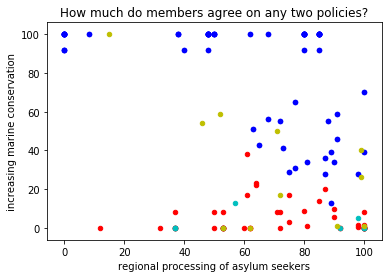

In [9]:
#%%
# How do politicians compare on policies?

pol_list = [i for i in range(1,241) if 
            'policy_'+str(i) in people_data.columns.tolist()]

policy1 = '16'
name1 = policy_details[int(policy1)-1]['name']
policy2 = '17'
name2 = policy_details[int(policy2)-1]['name']

main_parties = ['Australian Labor Party',
                'Liberal Party',
                'National Party',
                'Australian Greens']

partynames = people_data['party'].unique().tolist()
other = [i for i in partynames if i not in main_parties]

people_data['party'].tolist()

colors = ['b','r','c','g','m']

df = people_data[['party','policy_'+policy1,'policy_'+policy2]].copy()

df_ = df[['policy_'+policy1, 'policy_'+policy2]]
df[['policy_'+policy1, 'policy_'+policy2]] = df_.apply(pd.to_numeric)


ax = df[df['party'] == main_parties[0]].plot(x='policy_'+policy1,
                                             y='policy_'+policy2,
                                             kind='scatter',
                                             legend=True,
                                             color=colors[0],
                                             title = "How much do members" 
                                             " agree on any two policies?")
for n in range(len(main_parties)-1):
    ax_ = df[df['party'] == main_parties[n]].plot(x='policy_'+policy1,
                                                  y='policy_'+policy2,
                                                  kind='scatter',
                                                  legend=True,
                                                  color=colors[n],
                                                  ax=ax)
    
ax_ = df[df['party'].isin(other)].plot(x='policy_'+policy1,
                                                     y='policy_'+policy2,
                                                     kind='scatter',
                                                     legend=True,
                                                     color='y',
                                                     ax=ax) 
ax.set_xlabel(name1)
ax.set_ylabel(name2)

We can already see there is a tendency for MP's to separate into clusters. Although the clusters correlate with their party, sometimes a single party is split into clusters with ideological differences. And some clusters contain MPs from different parties. So we see that the clustering of "ideological profiles" crosses party boundaries and may be a much better indication of an MP's political values than the party they happen to belong to.

TODO: Run a clustering algorithm on the MP's ideological profiles for all 240 policies and see whether clusters can be reliably identified.